In [16]:
pip install statsmodels

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [18]:
!git clone 'https://github.com/HarshvardhanSingh-13/Datasets'

fatal: destination path 'Datasets' already exists and is not an empty directory.


In [19]:
df = pd.read_csv('/content/Datasets/Airline Timeseries/airline_passenger_timeseries.csv')

In [20]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [21]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


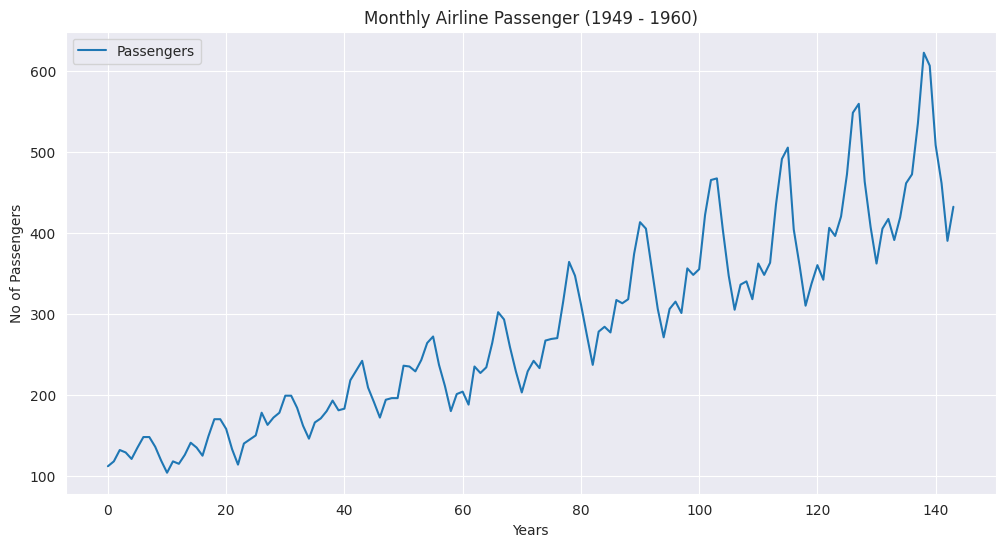

In [22]:
df.plot()
plt.title("Monthly Airline Passenger (1949 - 1960)")
plt.xlabel("Years")
plt.ylabel('No of Passengers')
plt.show()

In [23]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)

In [24]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [25]:
decomposition = sm.tsa.seasonal_decompose(df['Passengers'],model='multiplicative')

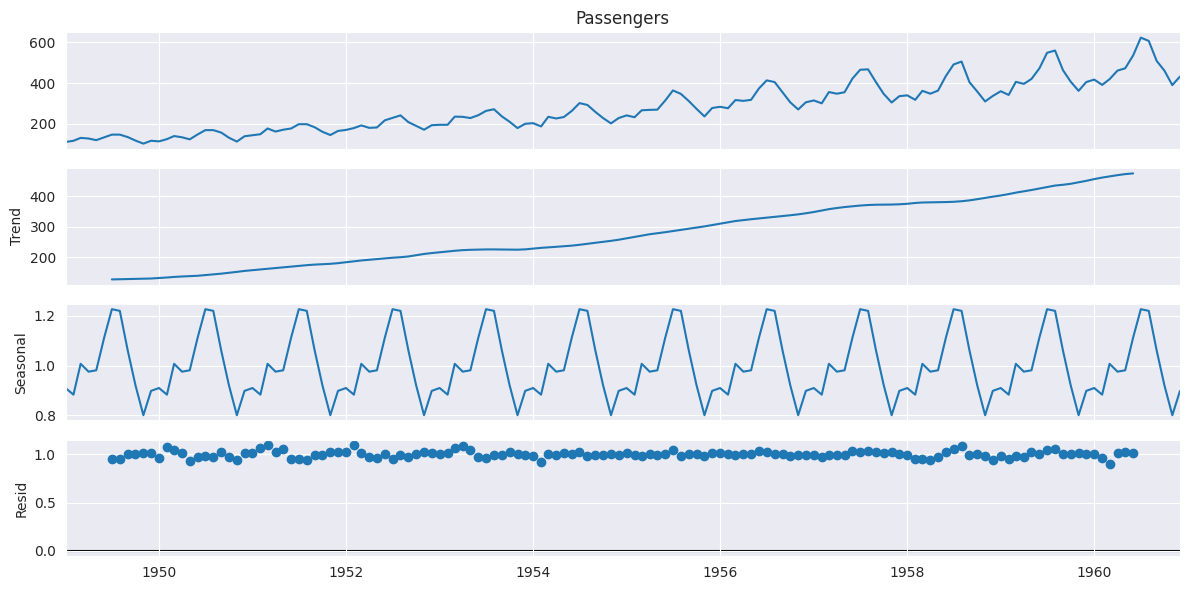

In [26]:
fig = decomposition.plot()
plt.show()

In [27]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Final p-value: 7.419304549376186e-13
Număr diferențieri (d) pentru ARIMA: 2


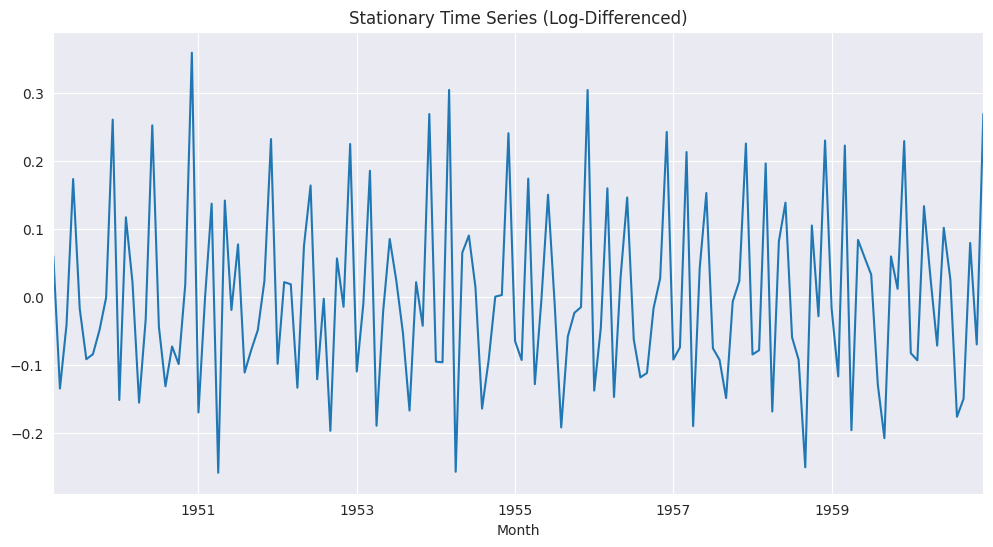

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [28]:
df_log = np.log(df['Passengers'])
df_diff = df_log.diff().dropna()


from statsmodels.tsa.stattools import adfuller

result = adfuller(df_diff)
d = 1
while result[1] > 0.05:
    df_diff = df_diff.diff().dropna()
    result = adfuller(df_diff)
    d += 1
print("Final p-value:", result[1])
print("Număr diferențieri (d) pentru ARIMA:", d)


df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

test_stationarity(df_diff)

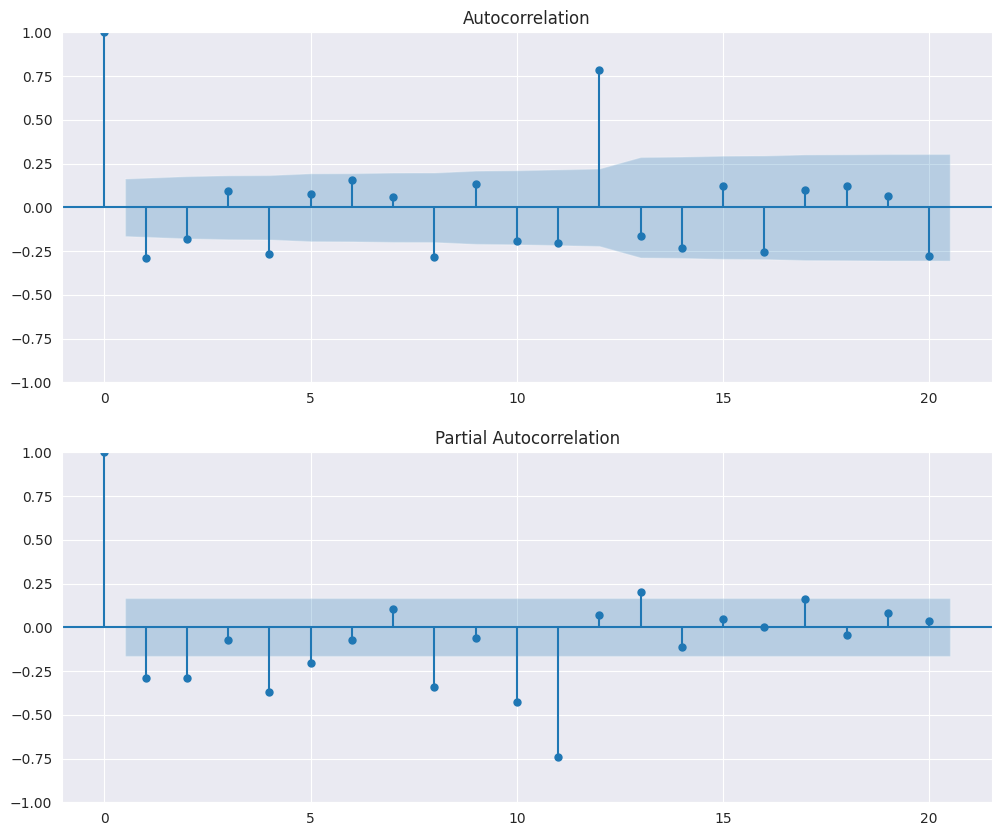

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


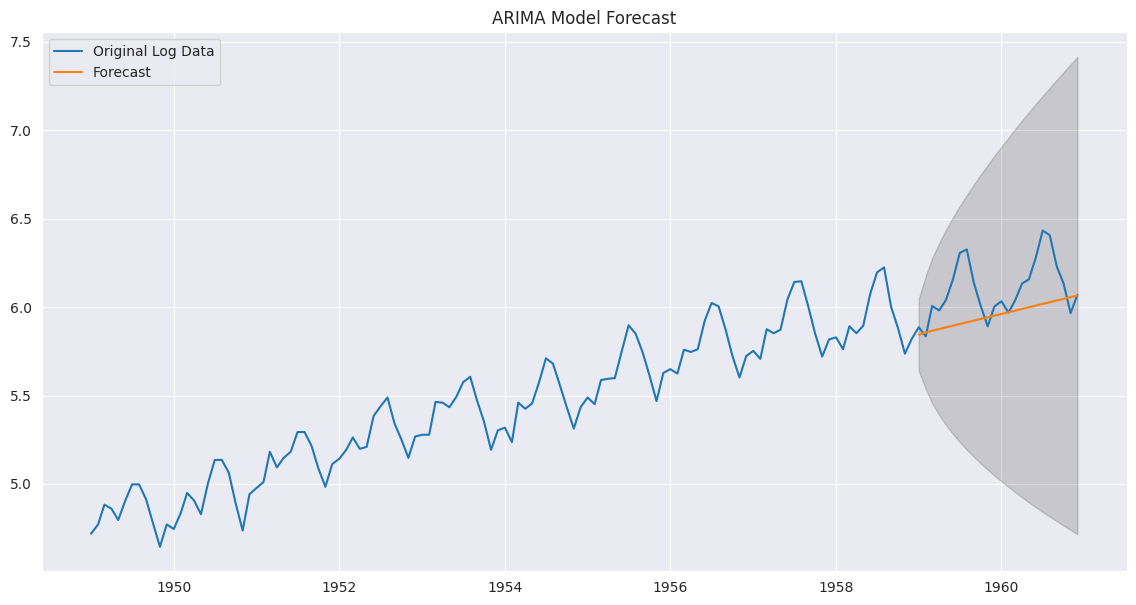

In [30]:
train_data = df_log[:'1958']
test_data = df_log['1959':]

model = ARIMA(train_data, order=(1, d, 1), freq='MS')
arima_result = model.fit()


forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()


plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()